In [1]:
import torch
print(torch.__version__)

1.8.0


In [1]:
import os
import shutil
import tempfile

# import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)

from monai.utils import set_determinism

import torch
from torch.utils.data import random_split



from math import floor

from typing import Union, List, Tuple


#################################################################

# Local imports

SOURCE_CODE_PATH = '../90_source_code/'

import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators_0p4 import RandFourierDiskMaskd
from utils import show_slice_and_fourier


# set determinism for reproducibility
set_determinism(seed=0)

print_config()

root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
#############################################################################

MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/


In [3]:
from filters_and_operators import ConvertToMultiChannelBasedOnBratsClassesd, SaltAndPepper 

from utils import show_slice_and_fourier

In [35]:
# SCRIPT PARAMETERS 
PP=0.35

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SaltAndPepper(PP)
        ]
)


In [36]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=2
)

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


In [37]:
data = val_ds[0]
img = data['image']

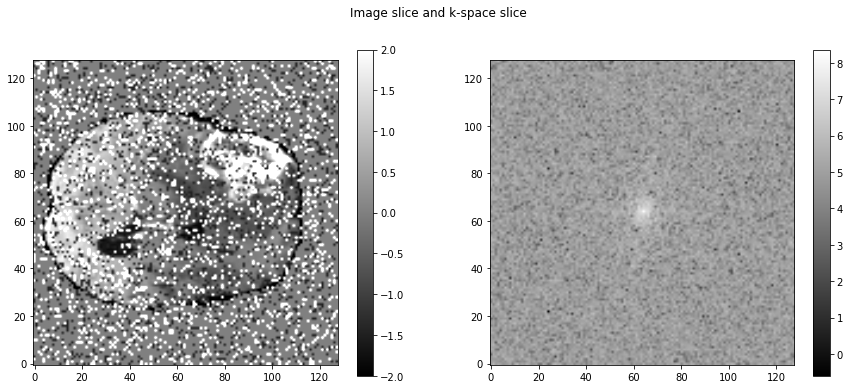

In [34]:
show_slice_and_fourier(img[2][:,:,32],level=0, window=4)

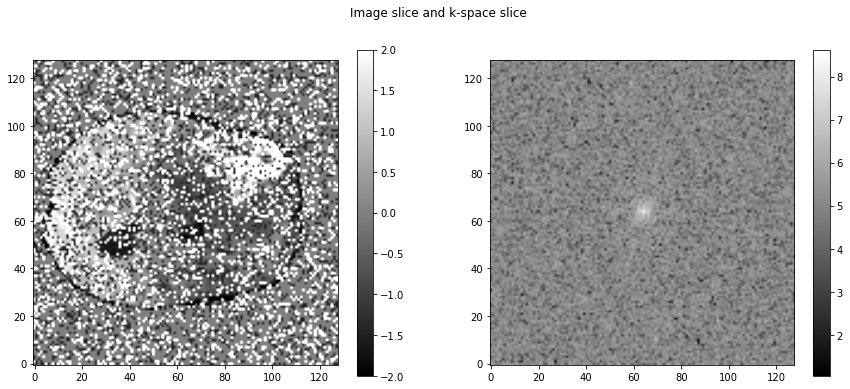

In [38]:
show_slice_and_fourier(img[2][:,:,32],level=0, window=4)

In [11]:
help(show_slice_and_fourier)

Help on function show_slice_and_fourier in module utils:

show_slice_and_fourier(img_2d: <built-in method tensor of type object at 0x7f2c641c0ca0>, level: Union[int, float] = None, window: Union[int, float] = None, level_f: Union[int, float] = None, window_f: Union[int, float] = None, title: str = None)
    Function to display image slice and corresponding fourier slice
    
    Args:
        img_2d = 2d tensor to image.
        level, window = mean amplitude, amplitude window around the mean/
        level_f, window_f = as above but for the fourier display.
        title = title for the image



In [9]:

# TODO change max_epochs to 180
max_epochs = 2  # 180
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

In [10]:
print('\n Training started... \n')

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}"
        #     f", train_loss: {loss.item():.4f}"
        #     )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

                metric = metric_sum / metric_count
                metric_values.append(metric)
                metric_tc = metric_sum_tc / metric_count_tc
                metric_values_tc.append(metric_tc)
                metric_wt = metric_sum_wt / metric_count_wt
                metric_values_wt.append(metric_wt)
                metric_et = metric_sum_et / metric_count_et
                metric_values_et.append(metric_et)

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(),
                        os.path.join(root_dir, f"best_metric_model_Gibbs{MASK_RADIUS}.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                    f"\nbest mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )


 Training started... 

----------
epoch 1/2
epoch 1 average loss: 0.9310
----------
epoch 2/2
epoch 2 average loss: 0.9215
saved new best metric model
current epoch: 2 current mean dice: 0.2063 tc: 0.1340 wt: 0.4263 et: 0.0585
best mean dice: 0.2063 at epoch: 2
saved new best metric model
current epoch: 2 current mean dice: 0.2661 tc: 0.2203 wt: 0.4774 et: 0.1006
best mean dice: 0.2661 at epoch: 2
saved new best metric model
current epoch: 2 current mean dice: 0.2751 tc: 0.2343 wt: 0.4877 et: 0.1033
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2621 tc: 0.2168 wt: 0.4758 et: 0.0938
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2425 tc: 0.1974 wt: 0.4494 et: 0.0807
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2325 tc: 0.1840 wt: 0.4400 et: 0.0736
best mean dice: 0.2751 at epoch: 2
current epoch: 2 current mean dice: 0.2159 tc: 0.1737 wt: 0.4066 et: 0.0675
best mean dice: 0.2751 at epoch: 2
current epoch: 